In [101]:
import pandas as pd
import numpy as np
import copy
import sys
from datetime import datetime
import argparse
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score as auprc
from sklearn.metrics import roc_auc_score as auc_score
import keras
from keras.utils import multi_gpu_model
from keras.layers import Input, Dense, GRU, Lambda, Permute, LSTM
from keras.models import Model
from interpolation_layer import single_channel_interp, cross_channel_interp
import warnings
from sklearn.preprocessing import KBinsDiscretizer
warnings.filterwarnings("ignore")
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MaxAbsScaler, MinMaxScaler

In [90]:
admission = pd.read_csv('Dataset_bench/with_age.csv')
# admission = admission[["HADM_ID", "ADMISSION_TYPE", "LOS"]]
# admission = admission[admission['LOS'] > 1]
# admission = admission[admission['LOS'] < 10]
admission = admission[["HADM_ID", "ADMISSION_TYPE", "EXPIRE_FLAG"]]
# admission['LOS'] = admission['LOS']
admission.head()

,HADM_ID,ADMISSION_TYPE,EXPIRE_FLAG
0,165315,EMERGENCY,0
1,152223,ELECTIVE,0
2,124321,EMERGENCY,0
3,161859,EMERGENCY,0
4,129635,EMERGENCY,0


In [3]:
# heart rate
item_hr = pd.read_csv('gru_features/HR.csv')
item_hr['CHARTTIME'] = pd.to_datetime(item_hr['CHARTTIME']).dt.tz_localize(None)
item_hr = item_hr[item_hr['VALUE'].notna()]

In [4]:
# dbp
item_dbp = pd.read_csv('gru_features/dbp.csv')
item_dbp['CHARTTIME'] = pd.to_datetime(item_dbp['CHARTTIME']).dt.tz_localize(None)
item_dbp = item_dbp[item_dbp['VALUE'].notna()]

In [5]:
# glucose
item_glucose = pd.read_csv('gru_features/HR.csv')
item_glucose['CHARTTIME'] = pd.to_datetime(item_glucose['CHARTTIME']).dt.tz_localize(None)
item_glucose = item_glucose[item_glucose['VALUE'].notna()]

In [6]:
# ph
item_ph = pd.read_csv('gru_features/ph.csv')
item_ph['CHARTTIME'] = pd.to_datetime(item_ph['CHARTTIME']).dt.tz_localize(None)
item_ph = item_ph[item_ph['VALUE'].notna()]

In [7]:
# rr
item_rr = pd.read_csv('gru_features/RR.csv')
item_rr['CHARTTIME'] = pd.to_datetime(item_rr['CHARTTIME']).dt.tz_localize(None)
item_rr = item_rr[item_rr['VALUE'].notna()]

In [8]:
# sbp
item_sbp = pd.read_csv('gru_features/sbp.csv')
item_sbp['CHARTTIME'] = pd.to_datetime(item_sbp['CHARTTIME']).dt.tz_localize(None)
item_sbp = item_sbp[item_sbp['VALUE'].notna()]

In [9]:
# spo2
item_spo2 = pd.read_csv('gru_features/SpO2.csv')
item_spo2['CHARTTIME'] = pd.to_datetime(item_spo2['CHARTTIME']).dt.tz_localize(None)
item_spo2 = item_spo2[item_spo2['VALUE'].notna()]

In [10]:
# temp
item_temp = pd.read_csv('gru_features/temp.csv')
item_temp['CHARTTIME'] = pd.to_datetime(item_temp['CHARTTIME']).dt.tz_localize(None)
item_temp = item_temp[item_temp['VALUE'].notna()]

In [11]:
# tgcs
item_tgcs = pd.read_csv('gru_features/tgcs.csv')
item_tgcs['CHARTTIME'] = pd.to_datetime(item_tgcs['CHARTTIME']).dt.tz_localize(None)
item_tgcs = item_tgcs[item_tgcs['VALUE'].notna()]

In [12]:
# uo
item_uo = pd.read_csv('gru_features/uo.csv')
item_uo['CHARTTIME'] = pd.to_datetime(item_uo['CHARTTIME']).dt.tz_localize(None)
item_uo = item_uo[item_uo['VALUE'].notna()]

In [21]:
scaler =  MinMaxScaler()
item_dbp[['VALUE']] = scaler.fit_transform(item_dbp[['VALUE']])
item_glucose[['VALUE']] = scaler.fit_transform(item_glucose[['VALUE']])
item_hr[['VALUE']] = scaler.fit_transform(item_hr[['VALUE']])
item_ph[['VALUE']] = scaler.fit_transform(item_ph[['VALUE']])
item_rr[['VALUE']] = scaler.fit_transform(item_rr[['VALUE']])
item_sbp[['VALUE']] = scaler.fit_transform(item_sbp[['VALUE']])
item_spo2[['VALUE']] = scaler.fit_transform(item_spo2[['VALUE']])
item_temp[['VALUE']] = scaler.fit_transform(item_temp[['VALUE']])
item_tgcs[['VALUE']] = scaler.fit_transform(item_tgcs[['VALUE']])
item_uo[['VALUE']] = scaler.fit_transform(item_uo[['VALUE']])

In [22]:
vitals_dict = {}
np.random.seed(10)
num_features = 10
max_length = 2000 # length of timestamp
gpu_num = 0
ref_points = 192
hid = 100
batch = 256
epoch = 50
num_ids = 500
hours_looks_ahead = 24
num_fold = 3
feature_set = 2
stds = []

In [54]:
label_lst = [1.00138889,  19.33532014, 118.87907366, 206.42569444]
cat1 = admission[admission['LOS'] < 3]
cat2 = admission[admission['LOS'].between(3, 7)]
cat3 = admission[admission['LOS'] > 7]
lens = [cat1.shape[0]/admission.shape[0],
        cat2.shape[0]/admission.shape[0],
        cat3.shape[0]/admission.shape[0]]
id1 = int(300 * 0.79)
id2 = int(300 * 0.18)
id3 = 300 - id1 - id2

# X for label 3:
cat1_ids = cat1['HADM_ID'].tolist()
cat2_ids = cat2['HADM_ID'].tolist()
cat3_ids = cat3['HADM_ID'].tolist()

needed_ids_cat1= cat1_ids[:300] + cat2_ids[:100] + cat3_ids[:100]
needed_ids_cat2= cat1_ids[:170] + cat2_ids[:65] + cat3_ids[:65]
needed_ids_cat3= cat1_ids[:65] + cat2_ids[:170] + cat3_ids[:165]

test_ids = cat1_ids[-5 :]+ cat2_ids[-5:]+ cat3_ids[-5:]

In [55]:
def select_ids(df):
    return df[df['HADM_ID'].isin(needed_ids_cat1)]

In [56]:
temp_dbp = select_ids(item_dbp)
temp_glucose = select_ids(item_glucose)
temp_hr = select_ids(item_hr)
temp_ph = select_ids(item_ph)
temp_rr = select_ids(item_rr)
temp_sbp = select_ids(item_sbp)
temp_spo2 = select_ids(item_spo2)
temp_temp = select_ids(item_temp)
temp_tgcs = select_ids(item_tgcs)
temp_uo = select_ids(item_uo)

In [57]:
# return two lists of hadm_id: list of timestamps (ascending order), list of corresponding vals of the item
def time_val_toLst(df, hadmin_id):
    temp = df.loc[df['HADM_ID'] == hadmin_id].sort_values(by=['CHARTTIME'])
    if not temp.empty: 
        times = temp.groupby('HADM_ID')['CHARTTIME'].apply(list).tolist()[0]
        vals = temp.groupby('HADM_ID')['VALUE'].apply(list).tolist()[0]
        return [times, vals]
    else:
        return [] # if id does not have this item, return empty list

In [58]:
def flatten(df, los=hours_looks_ahead):
    a = np.full((len(df), num_features, max_length), -100) # initlizae all as missing
    timestamps = []
    for i in range(len(df)):
        l = []
    
        # find all the unique observed timestamps
        for j in range(num_features):
            ts_ij = df[i][j]
            if ts_ij != []:
                for ts in df[i][j][0]:
                    if ts not in l:
                        l.append(ts)
        l.sort()
        T = copy.deepcopy(l)
        TS = []
        for t in T:
            if (t - T[0]).total_seconds() / 3600 <= los:
                TS.append(t)
        timestamps.append(TS)
        for j in range(num_features):
            s_ij = df[i][j]
            if s_ij != []:
                ts_ij = s_ij[0] 
                c_max = len(ts_ij)
                c = 0
                for k in range(len(TS)):
                    if c < c_max:
                        ts_ijc = ts_ij[c] # cur ts
                        diff = abs(TS[k] - ts_ijc).seconds / 60 # difference between ts's
                        if TS[k] == ts_ijc or diff < 5:
                            try:
                                a[i,j,k] = s_ij[1][c] 
                            except:
                                a[i,j,k] = -100
                            c += 1
    return a, timestamps

In [59]:
def input_format(x, T):
    real_len = 100
    
    for i in range(len(T)):
        if len(T[i]) > real_len:
            T[i] = T[i][:real_len]

    x = a[:, :, :real_len]
    M = np.zeros_like(x)
    delta = np.zeros_like(x)

    for t in T:
        for i in range(1, len(t)):
            t[i] = (t[i] - t[0]).total_seconds() / 3600 # hours difference
        if len(t) != 0:
            t[0] = 0
    
    # count outliers and negative values as missing values
    # M = 0 indicates missing value
    # M = 1 indicates observed value
    # now since we have mask variable, we don't need -100
    M[x > 500] = 0
    x[x > 500] = 0.0
    M[x < 0] = 0
    x[x < -30] = 0.0
    M[x > 0] = 1

    for i in range(num_features):
        for j in range(x.shape[0]):
            for k in range(len(T[j])):
                delta[j, i, k] = T[j][k]
    return x, M, delta

In [60]:
def missing_mean(M, x):
    counts = np.sum(np.sum(M, axis=2), axis=0)
    counts = [c + np.finfo(float).tiny for c in counts]
    mean_values = np.sum(np.sum(x*M, axis=2), axis=0)/counts
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if np.sum(M[i, j]) == 0:
                M[i, j, 0] = 1
                x[i, j, 0] = mean_values[j]
    return 

In [61]:
def hold_out(mask, perc=0.2):
    """To implement the autoencoder component of the loss, we introduce a set
    of masking variables mr (and mr1) for each data point. If drop_mask = 0,
    then we removecthe data point as an input to the interpolation network,
    and includecthe predicted value at this time point when assessing
    the autoencoder loss. In practice, we randomly select 20% of the
    observed data points to hold out from
    every input time series."""
    drop_mask = np.ones_like(mask)
    drop_mask *= mask
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            count = np.sum(mask[i, j], dtype='int')
            if int(0.20*count) > 1:
                index = 0
                r = np.ones((count, 1))
                b = np.random.choice(count, int(0.20*count), replace=False)
                r[b] = 0
                for k in range(mask.shape[2]):
                    if mask[i, j, k] > 0:
                        drop_mask[i, j, k] = r[index]
                        index += 1
    return drop_mask

In [62]:
# create the vitals dictionary: {id: [item1, item2, item3, item4, item5]}
# item1 = [list of timestamps, list of vals]
# only use the first 200 hadm_ids as sample

# 220045, spo2, rr,  
# needed_ids = adm_ids[:num_ids]
for adm_id in needed_ids_cat1:
    vitals_dict[adm_id] = [time_val_toLst(temp_sbp, adm_id)]
    vitals_dict[adm_id].append(time_val_toLst(temp_glucose, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_hr, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_ph, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_rr, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_sbp, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_spo2, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_temp, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_tgcs, adm_id))
    vitals_dict[adm_id].append(time_val_toLst(temp_uo, adm_id))
#     if feature_set == 2:
# #         vitals_dict[adm_id] = [time_val_toLst(item220739, adm_id)]
# #         vitals_dict[adm_id].append(time_val_toLst(item_sbp, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item220045, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item_temp, adm_id))
#         vitals_dict[adm_id].append(time_val_toLst(item_pf, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item_uo, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item51300, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item50882, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item50983, adm_id))
# #         vitals_dict[adm_id].append(time_val_toLst(item_po, adm_id))


In [63]:
stds = []
if feature_set == 2:
    stds.append(temp_dbp['VALUE'].std())
    stds.append(temp_glucose['VALUE'].std())
    stds.append(temp_hr['VALUE'].std())
    stds.append(temp_ph['VALUE'].std())
    stds.append(temp_rr['VALUE'].std())
    stds.append(temp_sbp['VALUE'].std())
    stds.append(temp_spo2['VALUE'].std())
    stds.append(temp_temp['VALUE'].std())
    stds.append(temp_tgcs['VALUE'].std())
    stds.append(temp_uo['VALUE'].std())

# if feature_set == 2:
#     stds.append(item220739['VALUENUM'].std())
#     stds.append(item_sbp['VALUENUM'].std())
#     stds.append(item220045['VALUENUM'].std())
#     stds.append(item_temp['VALUENUM'].std())
#     stds.append(item_pf['VALUENUM'].std())
#     stds.append(item_uo['VALUENUM'].std())
#     stds.append(item51300['VALUENUM'].std())
#     stds.append(item50882['VALUENUM'].std())
#     stds.append(item50983['VALUENUM'].std())
#     stds.append(item_po['VALUENUM'].std())

In [64]:
def y_trans(val):
    if val < 3:
        return 1.0
    else:
        return 0.0

In [94]:
vitals = [vitals_dict[x] for x in needed_ids_cat1] # hadm_id(los>=48h): all the vitals values
label = [admission[admission['HADM_ID'] == adm_id]['EXPIRE_FLAG'].values[0] for adm_id in needed_ids_cat1]

In [66]:
# # vitals = [vitals_dict[x] for x in needed_ids] # hadm_id(los>=48h): all the vitals values
# kb = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
# label = kb.fit_transform(admission.LOS.to_numpy().reshape(-1,1))
# # label = admission[admission['HADM_ID'].isin(needed_ids)].LOS.tolist()
# # label = [y_trans(l) for l in label]
# print(kb.bin_edges_)

In [95]:
a, ts = flatten(vitals, hours_looks_ahead)
x, m, T = input_format(a, ts)
missing_mean(m, x)
X = np.concatenate((x, m, T, hold_out(m)), axis=1)  # input format
y = np.array(label)
print(X.shape, y.shape)
timestamp = X.shape[2]
num_features = X.shape[1] // 4

(500, 40, 100) (500,)


In [96]:
# [17.3, 22, 22.45, 2.32, 23.41，5.7, 3.33, 14.1]
def customloss(ytrue, ypred):
    """ Autoencoder loss
    """
    num_fs = num_features
    # standard deviation of each feature mentioned in paper for MIMIC_III data
    wc = np.array(stds)
    print(wc.shape, ytrue.shape)
    wc.shape = (1, num_fs)
    y = ytrue[:, :num_fs, :]
    m2 = ytrue[:, 3*num_fs:4*num_fs, :]
    m2 = 1 - m2
    m1 = ytrue[:, num_fs:2*num_fs, :]
    m = m1*m2
    ypred = ypred[:, :num_fs, :]
    x = (y - ypred)*(y - ypred)
    x = x*m
    count = tf.reduce_sum(m, axis=2)
    count = tf.where(count > 0, count, tf.ones_like(count))
    x = tf.reduce_sum(x, axis=2)/count
    x = x/(wc**2)  # dividing by standard deviation
    x = tf.reduce_sum(x, axis=1)/num_fs
    return tf.reduce_mean(x)

In [102]:
def interp_net():
    num_fs = num_features
    if gpu_num > 1:
        dev = "/cpu:0"
    else:
        dev = "/gpu:0"
    with tf.device(dev):
        main_input = Input(shape=(4*num_fs, timestamp), name='input')
        sci = single_channel_interp(ref_points, hours_looks_ahead)
        cci = cross_channel_interp()
        interp = cci(sci(main_input))
        reconst = cci(sci(main_input, reconstruction=True),
                      reconstruction=True)
        aux_output = Lambda(lambda x: x, name='aux_output')(reconst)
        z = Permute((2, 1))(interp)
        z = GRU(hid, activation='tanh', recurrent_dropout=0.2, dropout=0.2)(z)
        main_output = Dense(1, activation='sigmoid', name='main_output')(z)
        orig_model = Model([main_input], [main_output, aux_output])
    if gpu_num > 1:
        model = multi_gpu_model(orig_model, gpus=gpu_num)
    else:
        model = orig_model
    print(orig_model.summary())
    return model

In [103]:
seed = 0
results = {}
results['loss'] = []
results['auc'] = []
results['acc'] = []
results['auprc'] = []
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0000, patience=20, verbose=0)
callbacks_list = [earlystop]
# ys = {}
# ys['y_pred'] = []
# ys['y_test'] = []

In [104]:
i = 0
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kfold.split(np.zeros(len(y)), y):
    print("Running Fold:", i+1)
    model1 = interp_net()  # re-initializing every time
    model1.compile(
        optimizer='adam',
        loss={'main_output': 'binary_crossentropy', 'aux_output': customloss},
        loss_weights={'main_output': 1., 'aux_output': 1.},
        metrics={'main_output': 'accuracy'})
    history1 = model1.fit(
        {'input': X[train]}, {'main_output': y[train], 'aux_output': X[train]},
        batch_size=batch,
        callbacks=callbacks_list,
        nb_epoch=50,
        validation_split=0.20,
        verbose=2)
    y_pred = model1.predict(X[test], batch_size=batch)
    y_pred = y_pred[0]
    total_loss, score, reconst_loss, acc = model1.evaluate(
        {'input': X[test]},
        {'main_output': y[test], 'aux_output': X[test]},
        batch_size=batch,
        verbose=0)
    results['loss'].append(score)
    results['acc'].append(acc)
    results['auc'].append(auc_score(y[test], y_pred))
    results['auprc'].append(auprc(y[test], y_pred))
#     ys['y_pred'].append(y_pred)
#     ys['y_test'].append(y_test)
    print(results)
    i += 1

Running Fold: 1
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40, 100)      0                                            
__________________________________________________________________________________________________
single_channel_interp_11 (singl multiple             10          input[0][0]                      
                                                                 input[0][0]                      
__________________________________________________________________________________________________
cross_channel_interp_11 (cross_ multiple             100         single_channel_interp_11[0][0]   
                                                                 single_channel_interp_11[1][0]   
___________________________________________________________________________

{'loss': [0.6924468874931335], 'auc': [0.5714285714285714], 'acc': [0.5699999928474426], 'auprc': [0.5914705177305478]}
Running Fold: 2
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40, 100)      0                                            
__________________________________________________________________________________________________
single_channel_interp_12 (singl multiple             10          input[0][0]                      
                                                                 input[0][0]                      
__________________________________________________________________________________________________
cross_channel_interp_12 (cross_ multiple             100         single_channel_interp_12[0][0]   
                                                      

Epoch 26/50
 - 6s - loss: 0.6861 - main_output_loss: 0.6941 - aux_output_loss: 2.1116e-13 - main_output_accuracy: 0.5625 - val_loss: 0.6636 - val_main_output_loss: 0.6636 - val_aux_output_loss: 1.6549e-13 - val_main_output_accuracy: 0.5625
Epoch 27/50
 - 6s - loss: 0.6778 - main_output_loss: 0.6824 - aux_output_loss: 2.6157e-13 - main_output_accuracy: 0.5688 - val_loss: 0.6673 - val_main_output_loss: 0.6673 - val_aux_output_loss: 1.0985e-13 - val_main_output_accuracy: 0.5625
Epoch 28/50
 - 6s - loss: 0.6782 - main_output_loss: 0.6835 - aux_output_loss: 2.4101e-13 - main_output_accuracy: 0.5688 - val_loss: 0.6696 - val_main_output_loss: 0.6696 - val_aux_output_loss: 9.3821e-14 - val_main_output_accuracy: 0.5625
Epoch 29/50
 - 6s - loss: 0.6878 - main_output_loss: 0.6748 - aux_output_loss: 2.0919e-13 - main_output_accuracy: 0.5312 - val_loss: 0.6728 - val_main_output_loss: 0.6728 - val_aux_output_loss: 1.1803e-13 - val_main_output_accuracy: 0.5625
Epoch 30/50
 - 6s - loss: 0.6864 - main_

Epoch 10/50
 - 6s - loss: 0.6746 - main_output_loss: 0.6733 - aux_output_loss: 6.1780e-13 - main_output_accuracy: 0.5656 - val_loss: 0.6745 - val_main_output_loss: 0.6745 - val_aux_output_loss: 8.9901e-14 - val_main_output_accuracy: 0.5125
Epoch 11/50
 - 6s - loss: 0.6857 - main_output_loss: 0.6861 - aux_output_loss: 2.2655e-13 - main_output_accuracy: 0.5562 - val_loss: 0.6758 - val_main_output_loss: 0.6758 - val_aux_output_loss: 2.0976e-13 - val_main_output_accuracy: 0.5125
Epoch 12/50
 - 6s - loss: 0.6828 - main_output_loss: 0.6817 - aux_output_loss: 2.2091e-13 - main_output_accuracy: 0.5562 - val_loss: 0.6763 - val_main_output_loss: 0.6763 - val_aux_output_loss: 1.2539e-13 - val_main_output_accuracy: 0.5125
Epoch 13/50
 - 6s - loss: 0.6933 - main_output_loss: 0.6890 - aux_output_loss: 2.0675e-13 - main_output_accuracy: 0.5375 - val_loss: 0.6760 - val_main_output_loss: 0.6760 - val_aux_output_loss: 1.9568e-13 - val_main_output_accuracy: 0.5125
Epoch 14/50
 - 6s - loss: 0.6797 - main_

 - 6s - loss: 0.6800 - main_output_loss: 0.6669 - aux_output_loss: 7.9347e-14 - main_output_accuracy: 0.5656 - val_loss: 0.6738 - val_main_output_loss: 0.6738 - val_aux_output_loss: 1.7097e-13 - val_main_output_accuracy: 0.5375
Epoch 6/50
 - 6s - loss: 0.6751 - main_output_loss: 0.6668 - aux_output_loss: 7.6209e-14 - main_output_accuracy: 0.5750 - val_loss: 0.6710 - val_main_output_loss: 0.6710 - val_aux_output_loss: 3.1153e-13 - val_main_output_accuracy: 0.5250
Epoch 7/50
 - 5s - loss: 0.6745 - main_output_loss: 0.6767 - aux_output_loss: 1.1530e-13 - main_output_accuracy: 0.5656 - val_loss: 0.6713 - val_main_output_loss: 0.6713 - val_aux_output_loss: 1.8085e-13 - val_main_output_accuracy: 0.5250
Epoch 8/50
 - 6s - loss: 0.6781 - main_output_loss: 0.6754 - aux_output_loss: 1.1031e-13 - main_output_accuracy: 0.5719 - val_loss: 0.6740 - val_main_output_loss: 0.6740 - val_aux_output_loss: 2.0752e-13 - val_main_output_accuracy: 0.5250
Epoch 9/50
 - 6s - loss: 0.6732 - main_output_loss: 0.6

Epoch 40/50
 - 6s - loss: 0.6720 - main_output_loss: 0.6707 - aux_output_loss: 1.4789e-13 - main_output_accuracy: 0.5813 - val_loss: 0.6775 - val_main_output_loss: 0.6775 - val_aux_output_loss: 2.5517e-13 - val_main_output_accuracy: 0.5000
Epoch 41/50
 - 7s - loss: 0.6815 - main_output_loss: 0.6872 - aux_output_loss: 1.2387e-13 - main_output_accuracy: 0.5719 - val_loss: 0.6821 - val_main_output_loss: 0.6821 - val_aux_output_loss: 2.5265e-13 - val_main_output_accuracy: 0.5000
Epoch 42/50
 - 6s - loss: 0.6771 - main_output_loss: 0.6859 - aux_output_loss: 1.0527e-13 - main_output_accuracy: 0.5688 - val_loss: 0.6842 - val_main_output_loss: 0.6842 - val_aux_output_loss: 2.6017e-13 - val_main_output_accuracy: 0.4875
Epoch 43/50
 - 6s - loss: 0.6751 - main_output_loss: 0.6770 - aux_output_loss: 1.2538e-13 - main_output_accuracy: 0.5688 - val_loss: 0.6824 - val_main_output_loss: 0.6824 - val_aux_output_loss: 2.4435e-13 - val_main_output_accuracy: 0.4875
Epoch 44/50
 - 6s - loss: 0.6685 - main_

Epoch 14/50
 - 6s - loss: 0.6708 - main_output_loss: 0.6708 - aux_output_loss: 2.0437e-13 - main_output_accuracy: 0.5844 - val_loss: 0.6796 - val_main_output_loss: 0.6796 - val_aux_output_loss: 1.9195e-13 - val_main_output_accuracy: 0.5250
Epoch 15/50
 - 6s - loss: 0.6760 - main_output_loss: 0.6784 - aux_output_loss: 2.0770e-13 - main_output_accuracy: 0.5906 - val_loss: 0.6775 - val_main_output_loss: 0.6775 - val_aux_output_loss: 3.1962e-13 - val_main_output_accuracy: 0.5250
Epoch 16/50
 - 6s - loss: 0.6699 - main_output_loss: 0.6613 - aux_output_loss: 2.2711e-13 - main_output_accuracy: 0.5750 - val_loss: 0.6757 - val_main_output_loss: 0.6757 - val_aux_output_loss: 1.0035e-13 - val_main_output_accuracy: 0.5250
Epoch 17/50
 - 7s - loss: 0.6867 - main_output_loss: 0.6932 - aux_output_loss: 2.0859e-13 - main_output_accuracy: 0.5562 - val_loss: 0.6720 - val_main_output_loss: 0.6720 - val_aux_output_loss: 2.8672e-13 - val_main_output_accuracy: 0.5250
Epoch 18/50
 - 7s - loss: 0.6799 - main_

In [72]:
history_dict = history1.history
history_dict.keys()

dict_keys(['val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_accuracy', 'loss', 'main_output_loss', 'aux_output_loss', 'main_output_accuracy'])

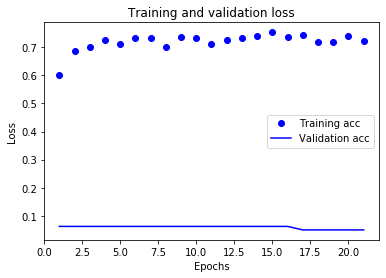

In [73]:
acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']
loss = history_dict['main_output_loss']
val_loss = history_dict['val_main_output_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
results

{'loss': [0.6918002963066101,
  0.6785474419593811,
  0.7042328715324402,
  0.693600594997406,
  0.6852771639823914],
 'auc': [0.5258333333333334,
  0.6522916666666667,
  0.4489583333333333,
  0.32687499999999997,
  0.48458333333333337],
 'acc': [0.5899999737739563,
  0.6000000238418579,
  0.41999998688697815,
  0.6000000238418579,
  0.5699999928474426],
 'auprc': [0.6221316391249946,
  0.6957140841781153,
  0.5959189425365962,
  0.5390679788048209,
  0.6029748897967951]}

In [320]:
!mkdir -p saved_model
model.save('saved_model/my_model') 
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

model1 model2
ls: saved_model/my_model: No such file or directory


Running Fold: 1
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40, 200)      0                                            
__________________________________________________________________________________________________
single_channel_interp_51 (singl multiple             10          input[0][0]                      
                                                                 input[0][0]                      
__________________________________________________________________________________________________
cross_channel_interp_51 (cross_ multiple             100         single_channel_interp_51[0][0]   
                                                                 single_channel_interp_51[1][0]   
___________________________________________________________________________

Epoch 24/30
 - 12s - loss: 349604184064.0000 - main_output_loss: 349604184064.0000 - aux_output_loss: 9.0885e-09 - main_output_accuracy: 0.4961 - val_loss: 0.8641 - val_main_output_loss: 0.8641 - val_aux_output_loss: 1.7928e-10 - val_main_output_accuracy: 0.0469
Epoch 25/30
 - 12s - loss: 601118081024.0000 - main_output_loss: 601118081024.0000 - aux_output_loss: 9.0901e-09 - main_output_accuracy: 0.5391 - val_loss: 0.8629 - val_main_output_loss: 0.8629 - val_aux_output_loss: 1.7928e-10 - val_main_output_accuracy: 0.0469
Epoch 26/30
 - 10s - loss: 22877684367360.0000 - main_output_loss: 22877684367360.0000 - aux_output_loss: 9.0916e-09 - main_output_accuracy: 0.4805 - val_loss: 0.8628 - val_main_output_loss: 0.8628 - val_aux_output_loss: 1.7931e-10 - val_main_output_accuracy: 0.0469
Epoch 27/30
 - 11s - loss: 2030308992.0000 - main_output_loss: 2030308992.0000 - aux_output_loss: 9.0933e-09 - main_output_accuracy: 0.5000 - val_loss: 0.8626 - val_main_output_loss: 0.8626 - val_aux_output_

Epoch 17/30
 - 12s - loss: 144335896576.0000 - main_output_loss: 144335896576.0000 - aux_output_loss: 6.9770e-09 - main_output_accuracy: 0.5039 - val_loss: 0.6271 - val_main_output_loss: 0.6271 - val_aux_output_loss: 2.1380e-10 - val_main_output_accuracy: 0.8594
Epoch 18/30
 - 11s - loss: 50434666496.0000 - main_output_loss: 50434666496.0000 - aux_output_loss: 6.9738e-09 - main_output_accuracy: 0.4062 - val_loss: 0.6269 - val_main_output_loss: 0.6269 - val_aux_output_loss: 2.1372e-10 - val_main_output_accuracy: 0.8750
Epoch 19/30
 - 11s - loss: 5751465574400.0000 - main_output_loss: 5751465574400.0000 - aux_output_loss: 6.9711e-09 - main_output_accuracy: 0.5078 - val_loss: 0.6264 - val_main_output_loss: 0.6264 - val_aux_output_loss: 2.1364e-10 - val_main_output_accuracy: 0.8750
Epoch 20/30
 - 11s - loss: 211801636864.0000 - main_output_loss: 211801636864.0000 - aux_output_loss: 6.9686e-09 - main_output_accuracy: 0.5039 - val_loss: 0.6261 - val_main_output_loss: 0.6261 - val_aux_output_

Epoch 13/30
 - 12s - loss: 22307556818944.0000 - main_output_loss: 22307556818944.0000 - aux_output_loss: 1.1411e-08 - main_output_accuracy: 0.4727 - val_loss: 0.6808 - val_main_output_loss: 0.6808 - val_aux_output_loss: 2.4256e-10 - val_main_output_accuracy: 0.6406
Epoch 14/30
 - 11s - loss: 59209399926784.0000 - main_output_loss: 59209399926784.0000 - aux_output_loss: 1.1411e-08 - main_output_accuracy: 0.4492 - val_loss: 0.6819 - val_main_output_loss: 0.6819 - val_aux_output_loss: 2.4262e-10 - val_main_output_accuracy: 0.6406
Epoch 15/30
 - 10s - loss: 12860686073856.0000 - main_output_loss: 12860686073856.0000 - aux_output_loss: 1.1410e-08 - main_output_accuracy: 0.5000 - val_loss: 0.6830 - val_main_output_loss: 0.6830 - val_aux_output_loss: 2.4265e-10 - val_main_output_accuracy: 0.6094
Epoch 16/30
 - 12s - loss: 772991418368.0000 - main_output_loss: 772991418368.0000 - aux_output_loss: 1.1409e-08 - main_output_accuracy: 0.4648 - val_loss: 0.6841 - val_main_output_loss: 0.6841 - val

Epoch 12/30
 - 10s - loss: 3184469475328.0000 - main_output_loss: 3184469475328.0000 - aux_output_loss: 1.1491e-08 - main_output_accuracy: 0.5156 - val_loss: 0.5400 - val_main_output_loss: 0.5400 - val_aux_output_loss: 1.5447e-10 - val_main_output_accuracy: 0.9375
Epoch 13/30
 - 12s - loss: 17320912093184.0000 - main_output_loss: 17320912093184.0000 - aux_output_loss: 1.1490e-08 - main_output_accuracy: 0.5000 - val_loss: 0.5389 - val_main_output_loss: 0.5389 - val_aux_output_loss: 1.5438e-10 - val_main_output_accuracy: 0.9375
Epoch 14/30
 - 11s - loss: 1046264807424.0000 - main_output_loss: 1046264807424.0000 - aux_output_loss: 1.1489e-08 - main_output_accuracy: 0.5273 - val_loss: 0.5376 - val_main_output_loss: 0.5376 - val_aux_output_loss: 1.5431e-10 - val_main_output_accuracy: 0.9375
Epoch 15/30
 - 11s - loss: 15449662160896.0000 - main_output_loss: 15449662160896.0000 - aux_output_loss: 1.1488e-08 - main_output_accuracy: 0.4844 - val_loss: 0.5372 - val_main_output_loss: 0.5372 - val

Epoch 4/30
 - 11s - loss: 6461757849600.0000 - main_output_loss: 6461757849600.0000 - aux_output_loss: 7.0699e-09 - main_output_accuracy: 0.5117 - val_loss: 0.6571 - val_main_output_loss: 0.6571 - val_aux_output_loss: 1.6985e-10 - val_main_output_accuracy: 0.7500
Epoch 5/30
 - 11s - loss: 39210627104768.0000 - main_output_loss: 39210627104768.0000 - aux_output_loss: 7.0702e-09 - main_output_accuracy: 0.5469 - val_loss: 0.6575 - val_main_output_loss: 0.6575 - val_aux_output_loss: 1.6983e-10 - val_main_output_accuracy: 0.7500
Epoch 6/30
 - 13s - loss: 208567554539520.0000 - main_output_loss: 208567554539520.0000 - aux_output_loss: 7.0704e-09 - main_output_accuracy: 0.4688 - val_loss: 0.6611 - val_main_output_loss: 0.6611 - val_aux_output_loss: 1.6981e-10 - val_main_output_accuracy: 0.7500
Epoch 7/30
 - 14s - loss: 19130415579136.0000 - main_output_loss: 19130415579136.0000 - aux_output_loss: 7.0716e-09 - main_output_accuracy: 0.4688 - val_loss: 0.6635 - val_main_output_loss: 0.6635 - val

In [83]:
dbp = item_dbp.groupby('HADM_ID')['CHARTTIME'].nunique().reset_index()
dbp = lst.sort_values(by=['CHARTTIME'], ascending=False
                      


In [88]:
dbp = lst.sort_values(by=['CHARTTIME'], ascending=False

,HADM_ID,CHARTTIME
17072,139697,26053
4627,110600,19717
15075,134966,13743
36959,186211,13213
5107,111736,11880
...,...,...
34187,179695,1
3608,108314,1
22387,152202,1
29954,169996,1


In [463]:
# model1 = tf.keras.models.load_model('saved_model/model1')
# model2 = tf.keras.models.load_model('saved_model/model2')
total_loss, score, reconst_loss, acc = model1.evaluate(
        {'input': X},
        {'main_output': y, 'aux_output': X},
        batch_size=batch,
        verbose=0)

In [466]:
y

array([1., 0., 1.])

In [508]:
0.66, 0.66, 0.66, 0.66

array([[0.7059831 ],
       [0.6919864 ],
       [0.6788149 ],
       [0.67883784],
       [0.699977  ],
       [0.6856109 ],
       [0.67114425],
       [0.7091113 ],
       [0.68451977],
       [0.72566384],
       [0.7211993 ],
       [0.671489  ],
       [0.6791837 ],
       [0.6807078 ],
       [0.67148787]], dtype=float32)

In [185]:
x = np.concatenate((x, m, T, hold_out(m)), axis=1)  # input format
y = np.array(label)
print(x.shape, y.shape)
timestamp = x.shape[2]
num_features = x.shape[1] // 4

[39, 38, 13, 33, 22, 2, 37, 21, 29, 32, 27, 31, 53, 35, 47, 30, 31, 44, 25, 28]